In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
%matplotlib inline

In [2]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=16, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [4]:
# Load the training, validation and test data
data_file = 'ProcessedData.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

In [10]:
# load the previously trained classifier
c_data_file = 'ClassifierData.p'
with open(c_data_file, mode='rb') as f:
    c_data = pickle.load(f)

svc = c_data['svc']
X_scaler = c_data['X_scaler']
color_space = c_data['color_space']
spatial_size = c_data['spatial_size']
hist_bins = c_data['hist_bins']
orient = c_data['orient']
pix_per_cell = c_data['pix_per_cell']
cell_per_block = c_data['cell_per_block']
hog_channel = c_data['hog_channel']
spatial_feat = c_data['spatial_feat']
hog_feat = c_data['hog_feat']
hist_feat = c_data['hist_feat']

#svc = joblib.load('svc.p') 
#X_scaler = joblib.load('X_scaler.p') 

## Check the score of the SVC
#print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
#print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
## Check the prediction time for a single sample
#t=time.time()
#n_predict = 100
#print('My SVC predicts: ', svc.predict(X_val[0:n_predict]))
#print('For these',n_predict, 'labels: ', y_val[0:n_predict])
#t2 = time.time()
#print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

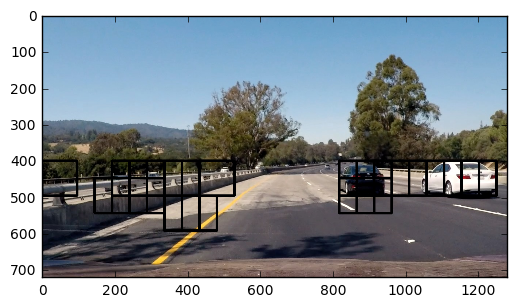

In [11]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

y_start_stop = [400, 600] # Min and max in y to search in slide_window()
y_start_stop = [200, None] # Min and max in y to search in slide_window()
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=6)                    

plt.imshow(window_img)

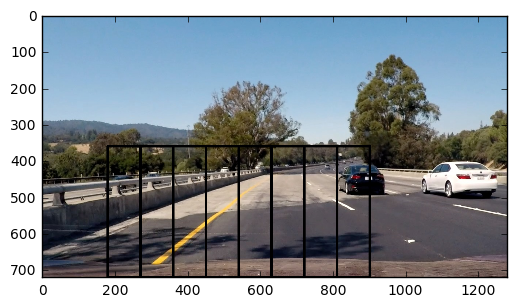

In [12]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

w,h=360,360
W,H=image.shape[1],image.shape[0]

y_start_stop = [H-h, H-h/2] # Min and max in y to search in slide_window()
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(w,h), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=6)                    

plt.imshow(window_img)

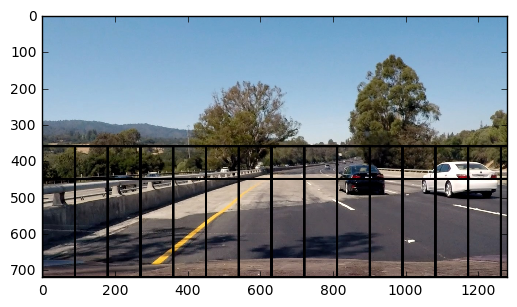

In [13]:
w,h=360,360
W,H=image.shape[1],image.shape[0]
y_start_stop = [H-h, H-h/4] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(w, h), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 1), thick=6)                    
plt.imshow(window_img)

In [14]:
len(hot_windows)

5

In [15]:
hot_windows[0]

((180, 360), (540, 720))